In [1]:
from datetime import datetime
dates = {'start_date':[], 'end_date':[]}
for i in range(2007,2020):
        dates['start_date'].append(datetime(i, 1, 1))
        dates['end_date'].append(datetime(i, 12, 31))
print(dates['start_date'][0])
print(dates['end_date'][0])

2007-01-01 00:00:00
2007-12-31 00:00:00


In [2]:
import base64
#from google.cloud import bigquery
import requests
from datetime import datetime, timedelta, date
import pandas as pd
import reverse_geocoder as rg
def actualizar_EEUU_sismo(request, context):
    project_id = 'henry-sismos'
    dataset_id = 'Sismos'
    table_id = 'EEUU_sismo'
    
    #table_ref = f"{project_id}.{dataset_id}.{table_id}"

    # Crear el cliente de BigQuery
    #client = bigquery.Client(project=project_id)

    
    # Verificar si se necesita actualizar la tabla
   
    # Calcular la fecha de inicio y fin para la API
    dates = {'start_date':[], 'end_date':[]}

    for i in range(2007,2020):
        dates['start_date'].append(datetime(i, 1, 1))
        dates['end_date'].append(datetime(i, 12, 31))
    
    records = []

    # Hace las peticiones necesarias para no sobrepasar el limite de 20000
    for i in range(len(dates['start_date'])):
        print(len(dates['start_date']) - i)
        # Obtener los datos de la API de USGS
        url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
        parameters = {
            'format': 'geojson',
            'starttime': dates['start_date'][i].strftime('%Y-%m-%d'),
            'endtime': dates['end_date'][i].strftime('%Y-%m-%d'),
            'minmagnitude': '2.5',
            'minlatitude': '12.555',
            'maxlatitude': '75.141',
            'minlongitude': '182.813',
            'maxlongitude': '315',
            'limit': 20000
        }
        response = requests.get(url, params=parameters)
        data = response.json()
        
        # Recorrer los eventos y extraer los parámetros
        for event in data['features']:
            properties = event['properties']
            latitude = event['geometry']['coordinates'][1]
            longitude = event['geometry']['coordinates'][0]
            longitude2 = event['geometry']['coordinates'][2]
            properties['latitude'] = latitude
            properties['longitude'] = longitude
            properties['hipocentro'] = longitude2
            records.append(properties)

    # Crear el DataFrame
    df_EEUU = pd.DataFrame(records)
    
    
    # Dar formato de fecha a la columna "time"
    df_EEUU["time"] = pd.to_datetime(df_EEUU["time"], unit="ms")
    # Eliminar filas con valores nulos
    df_EEUU = df_EEUU[["time", "mag", "cdi", "gap", "latitude", "longitude", "place", "ids", "hipocentro"]]
    
    df_EEUU = df_EEUU.dropna()
    
    # Verificar si el DataFrame está vacío
    if not df_EEUU.empty:
        # Verificar la longitud de las listas de coordenadas
        if len(df_EEUU['latitude']) == len(df_EEUU['longitude']):
            

            # Crear una lista de tuplas de coordenadas (latitud, longitud)
            coordinates = list(zip(df_EEUU['latitude'], df_EEUU['longitude']))
            
            # Realizar la búsqueda inversa de las coordenadas
            results = rg.search(coordinates)

            # Obtener la lista de regiones y países a partir de los resultados
            regions = [result['admin1'] if result['admin1'] != '' else 'Desconocido' for result in results]
            countries = [result['cc'] if result['cc'] != '' else 'Desconocido' for result in results]
            
            # Agregar las columnas "Region" y "Pais" al DataFrame
            df_EEUU['Region'] = regions
            df_EEUU['Pais'] = countries
            
            # Listado de valores permitidos en la columna 'Pais'
            paises_permitidos = ['US']

            # Filtrar las filas donde los valores de 'Pais' no coincidan con el listado
            df_EEUU = df_EEUU[df_EEUU['Pais'].isin(paises_permitidos)]

            # Renombrar las columnas
            nuevos_nombres = {'time': "Fecha", 'mag': "Magnitud", 'cdi': "Intensidad", 'gap': "GAP",
                                'latitude': "Latitud", 'longitude': "Longitud", 'place': "Lugar", 'ids': "Id" , "hipocentro": 'Hipocentro',
                                'Region': 'Region', 'Pais': 'Pais'}
            df_EEUU.rename(columns=nuevos_nombres, inplace=True)

            # Creamos la columna de la actualización de la data 
            df_EEUU["Act"] = pd.to_datetime(date.today()) 

            # EL RETURN SE DEBE ELIMINAR SÓLO SIRVE PARA EL TEST
            return df_EEUU
        
            '''
            # Insertar los datos en la tabla si hay nuevos datos
            if not df_EEUU.empty:
                # Definir el esquema para la tabla de BigQuery
                schema = [
                    bigquery.SchemaField("Fecha", "TIMESTAMP"),
                    bigquery.SchemaField("Magnitud", "FLOAT"),
                    bigquery.SchemaField("Intensidad", "FLOAT"),
                    bigquery.SchemaField("GAP", "FLOAT"),
                    bigquery.SchemaField("Latitud", "FLOAT"),
                    bigquery.SchemaField("Longitud", "FLOAT"),
                    bigquery.SchemaField('Hipocentro', 'FLOAT'),
                    bigquery.SchemaField('Lugar', 'STRING'),
                    bigquery.SchemaField('Id', 'STRING'),
                    bigquery.SchemaField('Region', 'STRING'),
                    bigquery.SchemaField('Pais', 'STRING'),
                    bigquery.SchemaField('Act', 'TIMESTAMP')
                ]

                # Actualizar la tabla en BigQuery
                job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_APPEND")
                job = client.load_table_from_dataframe(df_EEUU, table_ref, job_config=job_config)
                print("La tabla ha sido actualizada.")
            else:
                print("No hay nuevos datos para insertar.")

            
            
        else:
            print("La longitud de las listas de coordenadas no coincide.")
    else:
        print("El DataFrame df_EEUU está vacío.")'''

In [3]:
df_EEUU = actualizar_EEUU_sismo('','')

13
12
11
10
9
8
7
6
5
4
3
2
1
Loading formatted geocoded file...


In [4]:
df_EEUU

,Fecha,Magnitud,Intensidad,GAP,Latitud,Longitud,Lugar,Id,Hipocentro,Region,Pais,Act
340,2007-12-21 12:14:56.450,3.08,3.4,45.0,37.307833,-121.673500,"14 km E of Seven Trees, California",",nc51192926,usp000fuy9,ci10296225,",8.026,California,US,2023-07-12
381,2007-12-19 12:14:09.630,4.06,4.4,23.0,34.156167,-116.981333,"12km SSW of Big Bear Lake, CA",",ci10295849,usp000futa,",7.817,California,US,2023-07-12
505,2007-12-13 10:51:26.500,3.80,2.2,46.0,44.383000,-115.254000,"31 km NW of Stanley, Idaho",",usp000fucr,us2007kwa1,",17.900,Idaho,US,2023-07-12
631,2007-12-07 11:07:03.060,2.90,4.0,84.0,35.322667,-82.188833,"7 km N of Columbus, North Carolina",",sehwb1207a,se606565,usp000ftzq,",7.490,North Carolina,US,2023-07-12
656,2007-12-06 03:54:57.340,3.30,3.2,37.0,35.565833,-120.836167,"11 km W of Templeton, California",",nc40206955,usp000ftx0,ci10293265,",4.519,California,US,2023-07-12
...,...,...,...,...,...,...,...,...,...,...,...,...
138070,2019-01-02 15:47:03.600,2.91,4.9,63.0,38.577833,-112.259167,Utah,",uu60308782,us2000izup,",7.360,Utah,US,2023-07-12
138083,2019-01-02 06:40:31.910,2.60,2.0,42.0,36.097500,-97.883100,"2 km SE of Hennessey, OK",",us2000izs5,",5.000,Oklahoma,US,2023-07-12
138093,2019-01-02 00:41:36.100,2.80,2.0,132.0,36.368333,-121.499000,"16km SSW of Gonzales, CA",",nc73129231,",8.060,California,US,2023-07-12
138094,2019-01-01 22:59:54.860,3.26,3.1,30.0,40.887000,-123.477667,"14km ESE of Willow Creek, CA",",nc73129211,us2000izqu,",22.660,California,US,2023-07-12


In [5]:
df_EEUU['Fecha'].apply(lambda x: x.year).unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019], dtype=int64)

<AxesSubplot: xlabel='año', ylabel='count'>

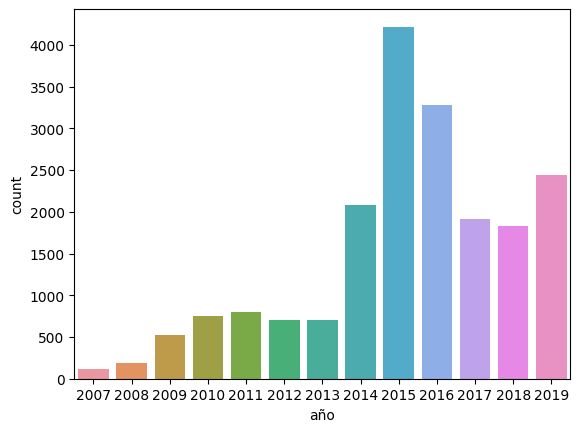

In [6]:
import requests
import pandas as pd #
import csv
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

df_EEUU['año'] = df_EEUU['Fecha'].apply(lambda x: x.year)

sns.countplot(df_EEUU, x='año')

Agregando las lineas de codigo de google cloud:

In [ ]:
import base64
from google.cloud import bigquery
import requests
from datetime import datetime, timedelta, date
import pandas as pd
import reverse_geocoder as rg
def actualizar_EEUU_sismo(request, context):
    project_id = 'henry-sismos'
    dataset_id = 'Sismos'
    table_id = 'EEUU_sismo'
    
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    # Crear el cliente de BigQuery
    client = bigquery.Client(project=project_id)

    
    # Verificar si se necesita actualizar la tabla
   
    # Calcular la fecha de inicio y fin para la API
    dates = {'start_date':[], 'end_date':[]}

    for i in range(2007,2020):
        dates['start_date'].append(datetime(i, 1, 1))
        dates['end_date'].append(datetime(i, 12, 31))
    
    records = []

    # Hace las peticiones necesarias para no sobrepasar el limite de 20000
    for i in range(len(dates['start_date'])):

        # Obtener los datos de la API de USGS
        url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
        parameters = {
            'format': 'geojson',
            'starttime': dates['start_date'][i].strftime('%Y-%m-%d'),
            'endtime': dates['end_date'][i].strftime('%Y-%m-%d'),
            'minmagnitude': '2.5',
            'minlatitude': '12.555',
            'maxlatitude': '75.141',
            'minlongitude': '182.813',
            'maxlongitude': '315',
            'limit': 20000
        }
        response = requests.get(url, params=parameters)
        data = response.json()
        
        # Recorrer los eventos y extraer los parámetros
        for event in data['features']:
            properties = event['properties']
            latitude = event['geometry']['coordinates'][1]
            longitude = event['geometry']['coordinates'][0]
            longitude2 = event['geometry']['coordinates'][2]
            properties['latitude'] = latitude
            properties['longitude'] = longitude
            properties['hipocentro'] = longitude2
            records.append(properties)

    # Crear el DataFrame
    df_EEUU = pd.DataFrame(records)
    
    
    # Dar formato de fecha a la columna "time"
    df_EEUU["time"] = pd.to_datetime(df_EEUU["time"], unit="ms")
    # Eliminar filas con valores nulos
    df_EEUU = df_EEUU[["time", "mag", "cdi", "gap", "latitude", "longitude", "place", "ids", "hipocentro"]]
    
    df_EEUU = df_EEUU.dropna()
    
    # Verificar si el DataFrame está vacío
    if not df_EEUU.empty:
        # Verificar la longitud de las listas de coordenadas
        if len(df_EEUU['latitude']) == len(df_EEUU['longitude']):
            

            # Crear una lista de tuplas de coordenadas (latitud, longitud)
            coordinates = list(zip(df_EEUU['latitude'], df_EEUU['longitude']))
            
            # Realizar la búsqueda inversa de las coordenadas
            results = rg.search(coordinates)

            # Obtener la lista de regiones y países a partir de los resultados
            regions = [result['admin1'] if result['admin1'] != '' else 'Desconocido' for result in results]
            countries = [result['cc'] if result['cc'] != '' else 'Desconocido' for result in results]
            
            # Agregar las columnas "Region" y "Pais" al DataFrame
            df_EEUU['Region'] = regions
            df_EEUU['Pais'] = countries
            
            # Listado de valores permitidos en la columna 'Pais'
            paises_permitidos = ['US']

            # Filtrar las filas donde los valores de 'Pais' no coincidan con el listado
            df_EEUU = df_EEUU[df_EEUU['Pais'].isin(paises_permitidos)]

            # Renombrar las columnas
            nuevos_nombres = {'time': "Fecha", 'mag': "Magnitud", 'cdi': "Intensidad", 'gap': "GAP",
                                'latitude': "Latitud", 'longitude': "Longitud", 'place': "Lugar", 'ids': "Id" , "hipocentro": 'Hipocentro',
                                'Region': 'Region', 'Pais': 'Pais'}
            df_EEUU.rename(columns=nuevos_nombres, inplace=True)

            # Creamos la columna de la actualización de la data 
            df_EEUU["Act"] = pd.to_datetime(date.today()) 
        
            
            # Insertar los datos en la tabla si hay nuevos datos
            if not df_EEUU.empty:
                # Definir el esquema para la tabla de BigQuery
                schema = [
                    bigquery.SchemaField("Fecha", "TIMESTAMP"),
                    bigquery.SchemaField("Magnitud", "FLOAT"),
                    bigquery.SchemaField("Intensidad", "FLOAT"),
                    bigquery.SchemaField("GAP", "FLOAT"),
                    bigquery.SchemaField("Latitud", "FLOAT"),
                    bigquery.SchemaField("Longitud", "FLOAT"),
                    bigquery.SchemaField('Hipocentro', 'FLOAT'),
                    bigquery.SchemaField('Lugar', 'STRING'),
                    bigquery.SchemaField('Id', 'STRING'),
                    bigquery.SchemaField('Region', 'STRING'),
                    bigquery.SchemaField('Pais', 'STRING'),
                    bigquery.SchemaField('Act', 'TIMESTAMP')
                ]

                # Actualizar la tabla en BigQuery
                job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_APPEND")
                job = client.load_table_from_dataframe(df_EEUU, table_ref, job_config=job_config)
                print("La tabla ha sido actualizada.")
            else:
                print("No hay nuevos datos para insertar.")

            
            
        else:
            print("La longitud de las listas de coordenadas no coincide.")
    else:
        print("El DataFrame df_EEUU está vacío.")